# Plotting user defined data in MAP and Tensorflow demo

## Installation of modules

Install the following python packages

```bash
pip install folium networkx osmnx
```

In linux, if you get this error when try to run `OSError: Could not find libspatialindex_c library file`
check this [site](https://stackoverflow.com/questions/45516181/why-cant-i-import-geopandas). It should fix everything.

### Plotting silchar map using folium

In [1]:
import folium
map = folium.Map(location=(24.7889848,92.7684591) ,width=400, height=400, zoom_start=12, no_touch=True)

In [2]:
map

This folium map object can be exported as html using `map.save('silchar.html')`

### Using networkx and osmnx

Important reference used are linked below:
- [github to osmnx docs](https://github.com/gboeing/osmnx-examples/tree/master/notebooks)
 - notebook number 00, 11
- [adding new feature to graph](https://stackoverflow.com/questions/13698352/storing-and-accessing-node-attributes-python-networkx)

In [3]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.8.1'

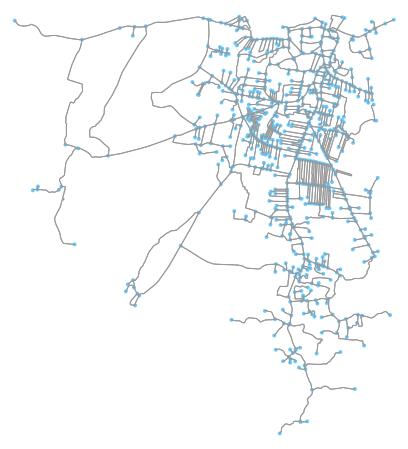

In [4]:

silchar = (24.7889848,92.7684591)

G = ox.graph_from_point(silchar, distance=5000, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=8)

#fig, ax = ox.plot_graph(G, fig_height=8, node_size=0)

## Routing (finding shortest path)

In [5]:
# startpoint and destination nodes
start_node = ox.get_nearest_node(G, (24.7726835,92.7880481))  # NIT Silchar
dest_node = ox.get_nearest_node(G, (24.8230026,92.7975493))    # Goldighi Shopping Mall

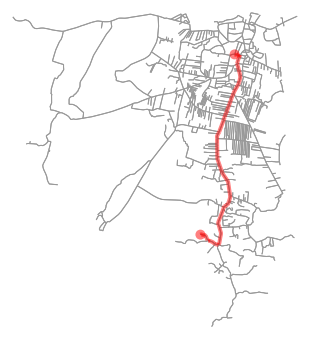

In [6]:
route = nx.shortest_path(G, start_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [7]:
# how long is our route in meters?
nx.shortest_path_length(G, start_node, dest_node, weight='length')

7134.186

plotting this route object in folium so that it can be exported

In [8]:
route_map = ox.plot_route_folium(G, route, tiles='OpenStreetMap',  route_opacity=0.7)

In [24]:
route_map
#route_map.save('./route.html')

---
## Creating new features and using them to find shortest path relative to new feature

In [10]:
import random

Create a safetiness dict which assigns random ratings to each edge. These ratings are fake, we have to replace with the actual ratings

Edges from the graph G can be called using G.edges

In [11]:
safetiness = { e:{'safety':round(random.uniform(0.0,5.0),2)} for e in G.edges}

In [12]:
len(G.edges)

1850

In [13]:
nx.set_edge_attributes(G,safetiness)

Let's test it

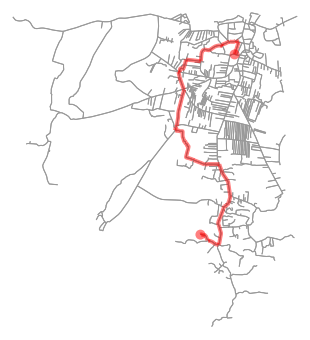

In [14]:
route_safe = nx.shortest_path(G, start_node, dest_node, weight='safety')
fig, ax = ox.plot_graph_route(G, route_safe, node_size=0)

This new route_safe can be plotted on folium and can be exported as shown above.

In [25]:
route_safef = ox.plot_route_folium(G, route_safe, tiles='OpenStreetMap',  route_opacity=0.7)
#route_safef.save('./route_safe.html')

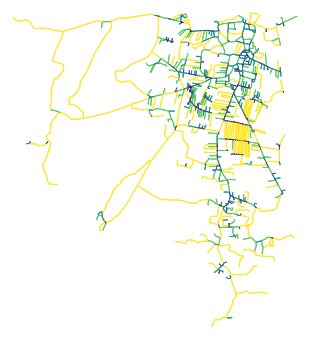

In [15]:
# show the network with edges colored by network length
ec = ox.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=0, node_zorder=3, edge_color=ec, edge_linewidth=1)

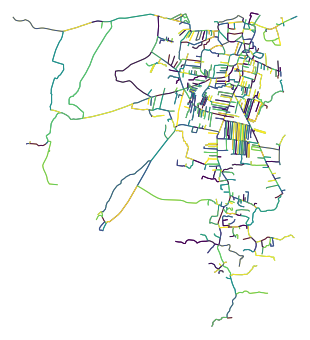

In [16]:
# show the network with edges colored by network fake safety
ec = ox.get_edge_colors_by_attr(G, attr='safety')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=0, node_zorder=3, edge_color=ec, edge_linewidth=1)

Clearly the above two graphs are different. Seems like it works

### How to replace fake ratings with real ones

Reference: [site](https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id)

In [17]:
gdfnode, gdfedge = ox.graph_to_gdfs(G)  #conert the networkx graph G to geePandas GeoDataFrame

In [18]:
type(gdfedge)

geopandas.geodataframe.GeoDataFrame

In [23]:
# get coordinates of an edge 0
list(gdfedge['geometry'][0].coords)

[(92.8029455, 24.8175138), (92.8036374, 24.8172918)]

We may send these coordinates back to our Model which will in turn send back actual safety ratings.

This is a demo and there is always room for development.

In [20]:
len(gdfedge)

1850

## Tensorflow 

The basic structure of our neural net shall consist of 4 or 5 `tf.DNNClassifier` objects depending on the amount of input we can provide. Idea is that each Classifier will be trained on different training data as follows :

 - NN1: on geographical features and infrastructure
   - Lighting in the Area
   - Openess of the Area
   - Visibility in the Area
   - Condition of roads and buildings
 - NN2: econimic aspects
   - Population density
   - Transportation and communication status(internet facilities)
   - Economic status of people in the area
   - Gender Diversity
 - NN3: crime aspects
   - amount/rate of crime in the area
   - security available for people in the area
   - media coverage

These area a few options that I can think of. We can add more on the way. Finally we calculate the probabilities predicted by each of these classifiers and add them to get get the final output as a rating out of 4 or 5 which depends on the number of Classifier used.

We will need to create a dataset which will contains data on above mentioned features with lattitude and longtitude as ID.

Once initial training is complete we can save the model ([reference](https://www.tensorflow.org/programmers_guide/saved_model)) and then restore and use whenever required.

Now.. What happens when new data arrives ?

Here's some reference to [tf.DNNClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier).